# A tour of transmorph *merging* modules

Merging algorithms are a special class of transformations which take as additional input similarity relationships between samples that were estimated via a matching. They return an integrated view of all datasets jointly embedded in a common feature space, so that matched items tend to be close from one another in the final representation. The embedding step is in general the last step in an integration model, and is chosen depending on the required output type. For instance, a joint embedding of datasets in an abstract space is suited for applications like visualization or clustering, while matrix factorization algorithms often require the embedding to be performed in an expressive feature space.

In this tutorial we will present the current available merging modules, as well as the way to implement custom merging modules.

## Toy dataset and plotting function

Let us start by loading a small dataset to illustrate our mergings, and defining a custom plotting function for them.

In [5]:
from transmorph.datasets import load_test_datasets_small

datasets = load_test_datasets_small()
datasets

{'src': AnnData object with n_obs × n_vars = 10 × 2
     obs: 'class',
 'ref': AnnData object with n_obs × n_vars = 9 × 2
     obs: 'class'}

In [61]:
import anndata as ad
import matplotlib.pyplot as plt
from typing import List, Optional

from mpl_toolkits.axes_grid1 import make_axes_locatable

SHAPES = ['s', 'o']
COLORS = ['red', 'blue']

def scatter_plot(datasets: List[ad.AnnData], use_rep: Optional[str] = None, plot_before: bool = False) -> None:
    """
    Custom scatter_plot function that can also plot a matching between dots.
    """
    fig = plt.figure(figsize=(5,5))
    ax_scatter = fig.add_subplot(111)
            
    # "Before" position
    if plot_before:
        ax_scatter.scatter([], [], marker="h", c="w", ec=COLORS[0], linestyle="--", label="Dataset src (before)")
        for dclass, shape in zip((0, 1), SHAPES):
            ax_scatter.scatter(
                *datasets['src'].X[datasets['src'].obs['class'] == dclass].T, 
                s=40,
                c="w",
                marker=shape,
                ec=COLORS[0],
                linestyle='--'
            )

    # Scatter plot
    for (adata_name, adata), color in zip(datasets.items(), COLORS):
        if use_rep is None:
            X = adata.X
        else:
            X = adata.obsm[use_rep]
        for dclass, shape in zip((0, 1), SHAPES):
            ax_scatter.scatter(
                *X[adata.obs['class'] == dclass].T,
                s=40,
                c=color,
                marker=shape
            )

    # Annotations
    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])
    ax_scatter.set_xlabel("Feature 1", fontsize=16)
    ax_scatter.set_ylabel("Feature 2", fontsize=16)

    # Legend outside of plot
    for (adata_name, adata), color in zip(datasets.items(), COLORS):
        ax_scatter.scatter([], [], c=color, marker="h", label=f"Dataset {adata_name}")
    for dclass, shape in zip((0, 1), SHAPES):
        ax_scatter.scatter([], [], c="k", marker=shape, label=f"Sample type {dclass}")

    divider = make_axes_locatable(ax_scatter)
    ax_legend = divider.append_axes("right", size="5%", pad=0.1)
    handles, labels = ax_scatter.get_legend_handles_labels()
    for label in labels:
        ax_legend.scatter([], [], label=label)
    legend = ax_legend.legend(
        handles,
        labels,
        fontsize=12,
        loc="center left",
    )
    ax_legend.axis("off")

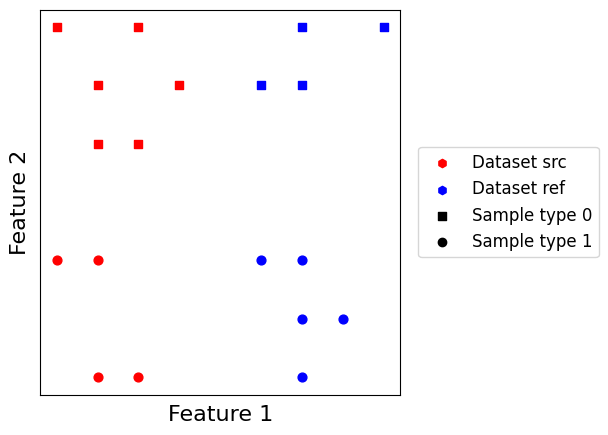

In [56]:
scatter_plot(datasets)

Let us also create a helper function which creates a minimal model using a given merging. Given we possess all class information about our toy dataset and it is quite small, we can use the "Labels" matching which connects together all samples with similar label across datasets.

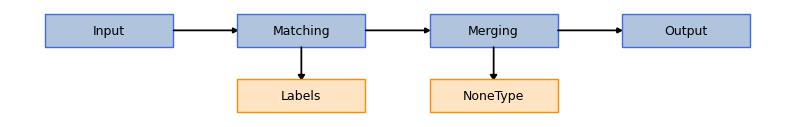

In [3]:
from transmorph.engine import Model
from transmorph.engine.layers import LayerInput, LayerMatching, LayerMerging, LayerOutput
from transmorph.engine.matching import Labels
from transmorph.utils.plotting import plot_model

def create_model_merging(merging=None):
    # Creates a minimalist model endowed with a set of transformations

    # Initializes layers
    layer_input = LayerInput()
    layer_matching = LayerMatching(matching=Labels(label_obs="class"))
    layer_merging = LayerMerging(merging=merging)
    layer_output = LayerOutput()

    # Setup connections
    layer_input.connect(layer_matching)
    layer_matching.connect(layer_merging)
    layer_merging.connect(layer_output)

    # Build model
    model = Model(input_layer=layer_input)
    return model

# Creating an empty model
plot_model(create_model_merging())

## Barycentric merging

Barycentric merging simply projects every cell onto the everage of its matches, weighted by the matching value. In our case, Labels matching associates to each edge a weight of one, effectively making an unweighted average. Barycentric merging requires a reference dataset to be set, and every cell in non-reference datasets to be matched otherwise they will me mapped to zero. On the other hand, it can work when datasets are embedded in non-overlapping spaces.

Her we set the blue dataset to be the reference, and we store the model result into AnnDatas .obsm field associated with key "X_barycenter".

In [43]:
from transmorph.engine.merging import Barycenter

model_barycenter = create_model_merging(Barycenter())
model_barycenter.fit(datasets, reference=datasets["ref"], output_representation="X_barycenter")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#47.
CUSTOM_MODEL > Running layer LAYER_MATCHING#48.
LAYER_MATCHING#48 > Calling matching MATCHING_LABELS.
CUSTOM_MODEL > Running layer LAYER_MERGING#49.
LAYER_MERGING#49 > Running merging MERGING_BARYCENTER...
CUSTOM_MODEL > Running layer LAYER_OUTPUT#50.
CUSTOM_MODEL > Terminated. Total embedding shape: (19, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_barycenter'].


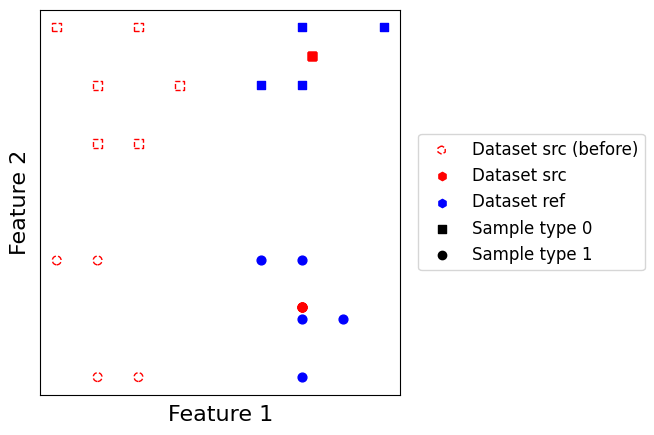

In [62]:
scatter_plot(datasets, use_rep="X_barycenter", plot_before=True)

Unsurprisingly, blue points are mapped to the barycenter of their corresponding class within the red dataset. This is due to the Labels which cause blue points of the same class to have the same matching points within the reference dataset.

## Linear correction merging

Inspired from Seurat, linear correction is a linear merging based on first computing a set of correction vectors, and then use them to correct batches with respect to a reference batch. It not only (1) necessitates to choose a reference batch, but also (2) for all batches to be embedded in a common feature space. It can work with incomplete matchings, meaning not every cell in the query batch necessitates to be matched with a cell in the reference batch. To correct a given batch, the algorithm follows a two-step process: it first computes correction vectors from matched samples to reference samples, and then extrapolates the correction vectors to the unmatched samples.

Doing so, it is able to correct cells which possess no match within the reference dataset if they are close enough from a matched cell. The downside is that correction must take place in a common feature space, which makes it unusable when datasets do not share common features. 

In [58]:
from transmorph.engine.merging import LinearCorrection

model_barycenter = create_model_merging(LinearCorrection(n_neighbors=3))
model_barycenter.fit(datasets, reference=datasets["ref"], output_representation="X_linearcorrection")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#51.
CUSTOM_MODEL > Running layer LAYER_MATCHING#52.
LAYER_MATCHING#52 > Calling matching MATCHING_LABELS.
CUSTOM_MODEL > Running layer LAYER_MERGING#53.
LAYER_MERGING#53 > Running merging MERGING_LINEAR_CORRECTION...
CUSTOM_MODEL > Running layer LAYER_OUTPUT#54.
CUSTOM_MODEL > Terminated. Total embedding shape: (19, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_linearcorrection'].


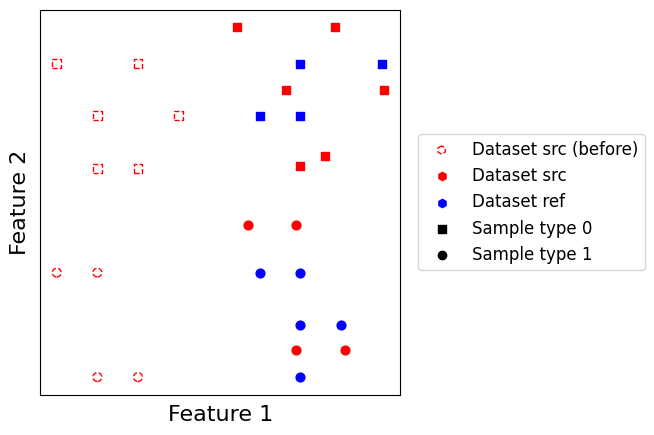

In [59]:
scatter_plot(datasets, use_rep="X_linearcorrection", plot_before=True)

As we can see, instead of collapsing every source point into one single position in the output representation, points are now separated after integration in a similar way than before integration.

## Graph embedding merging

Graph embedding is a non-linear embedding method which embeds a joint graph of datasets in a low dimensional space, similarly to what is done within the [CONOS](https://github.com/kharchenkolab/conos) pipeline. It combines both edges of the $k$-nearest neighbors graph of each dataset, and matching edges found between datasets to estimate the joint graph. It is then weighted and embedded using a solve (by default, the UMAP solver). 

This embedding is great in practice as it does not require a reference to be set. The main drawback is that the output feature space is "inexpressive", which is a major obstacle for interpretability. 

In [30]:
from transmorph.engine.merging import GraphEmbedding

model_barycenter = create_model_merging(GraphEmbedding(n_neighbors=3))
model_barycenter.fit(datasets, output_representation="X_graphembedding")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#31.
CUSTOM_MODEL > Running layer LAYER_MATCHING#32.
LAYER_MATCHING#32 > Calling matching MATCHING_LABELS.
CUSTOM_MODEL > Running layer LAYER_MERGING#33.
LAYER_MERGING#33 > Running merging MERGING_GRAPH_EMBEDDING...
CUSTOM_MODEL > Running layer LAYER_OUTPUT#34.
CUSTOM_MODEL > Terminated. Total embedding shape: (19, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_graphembedding_umap'].


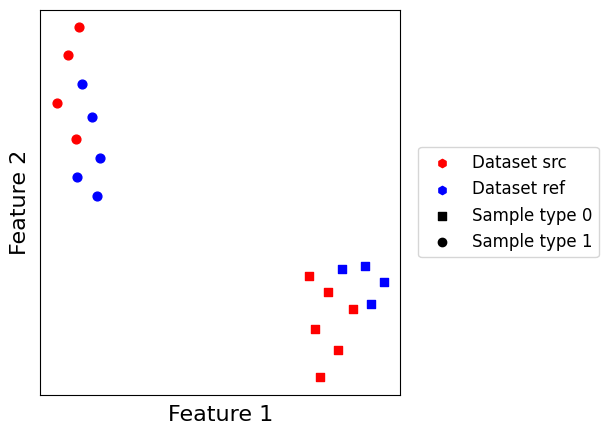

In [63]:
scatter_plot(datasets, use_rep="X_graphembedding_umap", plot_before=False)

## Implementing a custom merging

Like for transformations and matchings, you can define custom mergings to be used within **transmorph** pipelines. To illustrate it, let us implement a toy merging called "jittered barycenter" which works similarly to *Barycenter* merging, but which performs a small perturbation of the output to avoid stacking points with identical matches on top of one another. To do so, we simply generate for each point a sampling of a multivariate normal random variable around its "exact" position.

Each merging must inherit from the *Merging* class. In this case, we also want our merging to be able to handle a reference dataset, so we also make it inherit the *UsesReference* trait. We then just need to fill the *transform* method which returns a list describing the new embedding of each dataset.

In [73]:
import anndata as ad
import numpy as np

from scipy.stats import norm
from typing import List

from transmorph.engine.merging import Merging
from transmorph.engine.traits.usesreference import UsesReference
# As we want our merging to work with a reference, we
# must make it inherit the UsesReference trait.


# JitteredBarycenter is a Merging which must use a reference dataset
class JitteredBarycenter(Merging, UsesReference):

    def __init__(self, std: float = 0.05):
        # We must initialize both superclasses separately
        # preserves_space signals whether the input space for each
        # dataset is the same as the output space
        Merging.__init__(
            self,
            preserves_space=False, 
            str_identifier="PartialBarycenter",
            matching_mode="normalized",
        )
        UsesReference.__init__(self)
        # JitteredBarycenter parameter
        self.std = std

    def transform(
        self, datasets: List[ad.AnnData], embeddings: List[np.ndarray]
    ) -> List[np.ndarray]:
        # Inheriting the UsesReference trait allows us to
        # use the reference_index attribute, which contains
        # the reference index.
        k_ref = self.reference_index
        assert k_ref is not None, "Reference dataset must be set."
        X_ref = embeddings[k_ref] # We get the reference embedding
        result = []
        for k, X in enumerate(embeddings):
            if X is X_ref: # No need to change the reference
                result.append(X_ref)
                continue
            # Every Merging contains a get_matching(i, j) method
            # which accesses the matching matrix between datasets
            # i and j as a CSR matrix
            T = self.get_matching(k, k_ref)
            result.append(norm.rvs(loc=T @ X_ref, scale=self.std))
            
        # We return the list of new embeddings
        return result

In [77]:
model_barycenter = create_model_merging(JitteredBarycenter(std=0.2))
model_barycenter.fit(datasets, reference=datasets["ref"], output_representation="X_jitteredbarycenter")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 2 datasets, 19 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#71.
CUSTOM_MODEL > Running layer LAYER_MATCHING#72.
LAYER_MATCHING#72 > Calling matching MATCHING_LABELS.
CUSTOM_MODEL > Running layer LAYER_MERGING#73.
LAYER_MERGING#73 > Running merging MERGING_PartialBarycenter...
CUSTOM_MODEL > Running layer LAYER_OUTPUT#74.
CUSTOM_MODEL > Terminated. Total embedding shape: (19, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_jitteredbarycenter'].


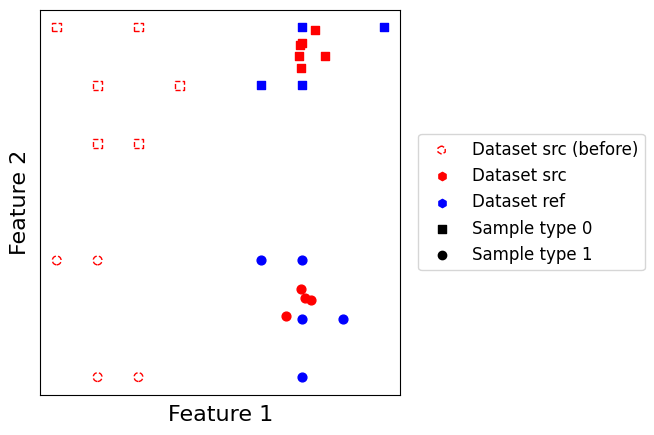

In [78]:
scatter_plot(datasets, use_rep="X_jitteredbarycenter", plot_before=True)

Perfect!